In [1]:
# import necessary modules
import numpy as np
import pandas as pd
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.animation as animation
from scipy import stats
from scipy.special import erfc
from scipy.signal import gaussian
from scipy.ndimage import convolve1d
import peakutils
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import random
from random import shuffle
import pickle
import copy
from src.codonTable import codonTable
from src.codonUtils import utils
from src.thunderflask import thunderflask
from src.bacteria import strain

sns.set_context("paper")
# get fast fail table
ff_path = '/home/jonathan/Dropbox/Lab/Fast Fail/res/Isaac-pickle-jar/FFpickles/'
with open(ff_path+'ff20_table.pickle', 'rb') as handle:
    fftable = codonTable(table=pickle.load(handle))
# get ff16 table
with open(ff_path+'ff16_table.pickle', 'rb') as handle:
    ff16_table = codonTable(table=pickle.load(handle))
# get reductionist code 
with open('/home/jonathan/Lab/Fast Fail/res/Reductionist Code/reductionist20.pickle', 'rb') as handle:
    red20 = codonTable(pickle.load(handle))

# get reduct14 code
with open('/home/jonathan/Lab/Fast Fail/res/Reductionist Code/reductionist14.pickle', 'rb') as handle:
    red14 = codonTable(pickle.load(handle))
    
# get promiscuous tables
promisc20 = codonTable(utils.promiscuity(red20.codonDict))
promisc14 = codonTable(utils.promiscuity(red14.codonDict))

# get random table
with open('res/random_table_manuscript.pickle', 'rb') as handle:
    rand = codonTable(table=pickle.load(handle))
    
# get standard code
sc = codonTable()  
# get colorado code
col = codonTable(table=utils.coloradoTable)

# define colors
orange = '#ef6c00'
blue = '#2196f3'
green = '#008000'

### Generate Random Tables

In [5]:
# define number of trials to run
N = 1000000
# preallocate memory for statistics
silencicities = np.zeros(N)
mutabilities = np.zeros(N)
# perform N trials
for i in tqdm(range(N)):
    # generage graph
    ct = utils.randomTable(wobble_rule='unrestricted')
    silencicities[i] = utils.silencicity(ct)
    mutabilities[i] = utils.mutability(ct)


100%|██████████| 1000000/1000000 [13:09<00:00, 1265.92it/s]


NameError: name 'rand_silencicities' is not defined

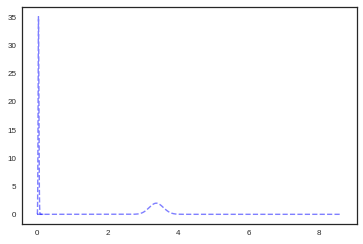

In [12]:
# perform fitting for two distributions
def fitter(array):
    # fit data
    s, loc, scale = stats.lognorm.fit(array)
    x = np.linspace(0, 2*max(array), 1000)
    pdf_fit = stats.lognorm.pdf(x, s, loc=loc, scale=scale)
    params = [s, loc, scale]
    plt.plot(x, pdf_fit, '--b', alpha=0.5, label='Fit')
    return x, pdf_fit, params
x_silence, pdf_silence, param_silence = fitter(silencicities)
x_mutate, pdf_mutate, param_mutate = fitter(mutabilities)

In [13]:
# pickle data for data permanence
to_dump = [silencicities, x_silence, pdf_silence, param_silence,
           mutabilities, x_mutate, pdf_mutate, param_mutate]
with open('res/fig1d.pickle', 'wb') as handle:
    pickle.dump(to_dump, handle)

## Figure 1: Genetic Codes Can Be Optimized for Desired Evolutionary Dynamics 

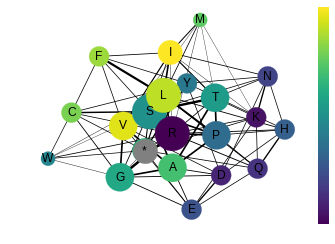

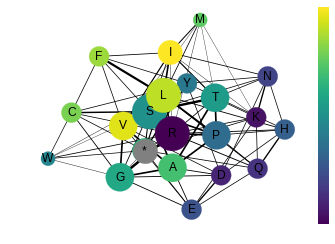

In [11]:
################
# Figures 1a-c #
################

# plot and save some shiznit
path = '/home/jonathan/Lab/Fast Fail/Figures/Figure 1/'
#rand.plotGraph(filename=path+'rand_graph.svg')
# sc.plotGraph()#filename=path+'sc_graph.svg')
#col.plotGraph(filename=path+'col_graph.svg')

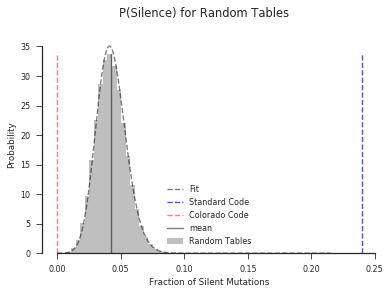

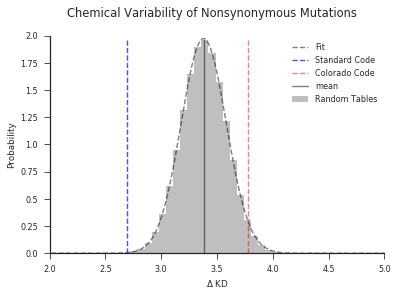

In [10]:
################
# Figures 1d-e #
################

# get data from pickle
with open('res/fig1d.pickle', 'rb') as handle:
    [silencicities, x_silence, pdf_silence, param_silence,
    mutabilities, x_mutate, pdf_mutate, param_mutate] = pickle.load(handle)
    
# Silencicity

# control aesthetics
sns.set_style('white')
sns.set_style('ticks')

# faster version of Silence plot: for when the values have already been calculated
#weights = np.ones(len(silencicities))/len(silencicities)
n, bins, patches = plt.hist(silencicities, 30, normed=1, #weights=weights,
                            color='grey', alpha=0.5, label='Random Tables')
plt.suptitle('P(Silence) for Random Tables')
plt.xlabel('Fraction of Silent Mutations')
plt.ylabel('Probability')
# fit data
def plotfit(x, pdf_fit):
    plt.plot(x, pdf_fit, '--k', alpha=0.5, label='Fit')
    return pdf_fit
plotfit(x_silence, pdf_silence)
#plt.xscale('log')
# define function for plotting individual lines given codonDict
def silentLiner(table, n, color, alpha, label):
    # calculate silencicities
    Silencicity = utils.silencicity(table.codonDict)
    Xs = np.ones(100)*Silencicity
    Ys = np.linspace(0, max(n), len(Xs))
    plt.plot(Xs, Ys, '--', color=color, alpha=alpha, label=label)
# plot line showing Standard Code
silentLiner(sc, n, 'blue', 0.7, 'Standard Code')
# plot line showing colorado code
silentLiner(col, n, 'red', 0.5, 'Colorado Code')
#plot line showing random table
value = silencicities.mean()
Xs = np.ones(100)*value
Ys = np.linspace(0, max(n), len(Xs))
plt.plot(Xs, Ys, '-', color='black', alpha=0.5, label='mean')
#plt.xlim([0, 0.25])
fig = plt.gcf()
ax = plt.gca()
#h, l = ax.get_legend_handles_labels()
#h = [h[-1], h[0], h[1]]
#l = [l[-1], l[0], l[1]]
ax.legend()#h, l)
sns.despine(trim=True)
#plt.savefig('/home/jonathan/Dropbox/Lab/Fast Fail/Figures/Figure 1/silencicity.svg', bbox_inches='tight')
plt.show()

# Mutability

# faster version of Silence plot: for when the values have already been calculated
#weights = np.ones(len(silencicities))/len(silencicities)
n, bins, patches = plt.hist(mutabilities, 30, normed=1, #weights=weights,
                            color='grey', alpha=0.5, label='Random Tables')
plt.suptitle('Chemical Variability of Nonsynonymous Mutations')
plt.xlabel(r'$\Delta$ KD')
plt.ylabel('Probability')
# fit data
plotfit(x_mutate, pdf_mutate)
#plt.xscale('log')
# define function for plotting individual lines given codonDict
def silentLiner2(table, n, color, alpha, label):
    # calculate silencicities
    mutability = utils.mutability(table.codonDict)
    Xs = np.ones(100)*mutability
    Ys = np.linspace(0, max(n), len(Xs))
    plt.plot(Xs, Ys, '--', color=color, alpha=alpha, label=label)
# plot line showing Standard Code
silentLiner2(sc, n, 'blue', 0.7, 'Standard Code')
# plot line showing colorado code
silentLiner2(col, n, 'red', 0.5, 'Colorado Code')
#plot line showing random table
value = mutabilities.mean()
Xs = np.ones(100)*value
Ys = np.linspace(0, max(n), len(Xs))
plt.plot(Xs, Ys, '-', color='black', alpha=0.5, label='mean')
# format ticks
loc, __ = plt.yticks()
ylabels = ['{0}'.format(num/4) for num in range(9)]
plt.yticks(loc, ylabels)
fig = plt.gcf()
ax = plt.gca()
#h, l = ax.get_legend_handles_labels()
#h = [h[-1], h[0], h[1]]
#l = [l[-1], l[0], l[1]]
ax.legend()#h, l
plt.ylim(0,2)
plt.xlim(2,5)
sns.despine()
# plt.savefig('/home/jonathan/Dropbox/Lab/Fast Fail/Figures/Figure 1/mutability.svg', bbox_inches='tight')
plt.show()

In [28]:
# calculate p value and 1 in foo of standard table silencicity
[s, loc, scale] = param_silence
z = (utils.silencicity(sc.codonDict) - loc) / scale
sig = np.log(z)/s
p = erfc(sig/np.sqrt(2))

oneInFoo = 1 / p
print('1 in {:.2e}'.format(oneInFoo))

1 in 1.01e+24


In [27]:
ticks = ['{0}'.format(num/4) for num in range(8)]
ticks

['0.0', '0.25', '0.5', '0.75', '1.0', '1.25', '1.5', '1.75']

In [50]:
sc_copy = copy.deepcopy(utils.standardTable)
aa_s = utils.residues
block_array = []
# loop over amino acids
for aa in aa_s:
    # get the block associated with that amino acid
    block = dict((key,value) for key, value in sc_copy.items() if value == aa)
    # store in block array
    block_array.append(block)

# loop over blocks
choices = []
for i, block in enumerate(block_array):
    # get choice
    choice = random.choice(list(block))
    # loop over codons in block
    for codon in list(block):
        # set all non-choice codons in block to stop
        if codon != choice: block[codon] = '*'
    # append choice to choices
    choices.append(choice)
print(block_array[3])

{'CUG': '*', 'UUG': '*', 'CUC': '*', 'UUA': 'L', 'CUU': '*', 'CUA': '*'}


## Figure 2: Fast Fail Genetic Codes Can Hinder Evolution

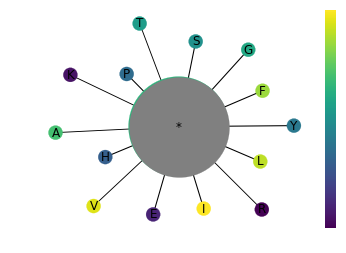

In [7]:
################
# Figures 2a-c #
################

# plot and save some shiznit
path = '/home/jonathan/Lab/Fast Fail/Figures/Figure 2/'
#fftable.codonTable.to_csv(path+'fftable.csv')
#fftable.plotGraph()#filename=path+'ff_graph.svg')
#ff16_table.codonTable.to_csv(path+'ff16.csv')
#f16_table.plotGraph(filename=path+'ff16_graph.svg')
# red20.plotGraph(filename=path+'reductionist_graph.svg')
# red20.codonTable.to_csv(path+'red20.csv')
# red14.plotGraph(filename=path+'reduct14_graph.svg')
# red14.codonTable.to_csv(path+'red14.csv')

In [8]:
red14.codonTable

U        C        A        G
U U  UUU : F  UCU : *  UAU : *  UGU : *
  C  UUC : *  UCC : *  UAC : Y  UGC : *
  A  UUA : *  UCA : S  UAA : *  UGA : *
  G  UUG : *  UCG : *  UAG : *  UGG : *
C U  CUU : *  CCU : *  CAU : H  CGU : *
  C  CUC : *  CCC : P  CAC : *  CGC : *
  A  CUA : *  CCA : *  CAA : *  CGA : R
  G  CUG : L  CCG : *  CAG : *  CGG : *
A U  AUU : *  ACU : *  AAU : *  AGU : *
  C  AUC : I  ACC : *  AAC : *  AGC : *
  A  AUA : *  ACA : *  AAA : K  AGA : *
  G  AUG : *  ACG : T  AAG : *  AGG : *
G U  GUU : *  GCU : A  GAU : *  GGU : *
  C  GUC : *  GCC : *  GAC : *  GGC : G
  A  GUA : V  GCA : *  GAA : *  GGA : *
  G  GUG : *  GCG : *  GAG : E  GGG : *

## Figure 3: Evolution is easier to arrest than accelerate 


Iteration Number: : 100%|██████████| 10000/10000 [02:47<00:00, 59.68it/s]


HBox(children=(IntProgress(value=0, description='Looping through all strains: ', max=20474), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='Plotting Lineages: ', max=1), HTML(value='')))

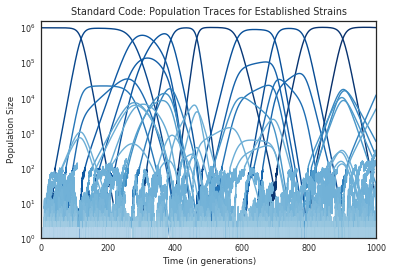

In [128]:
#############
# Figure 3a #
#############
# populate sim
LUCA = strain(N_pop=1e6, fitness=0, mu=2e-5)
sim = thunderflask(LUCA)
# initialize some variables
T_curr = 0
mut_param = [1, 2]
dt = 0.1
T_sim = 1000

# run simulation
sim.simulate(T_sim, dt, T_curr, mut_param, save_all=True, prune_strains=True,
             show_progress=True)

# plot results
strainlist = []
for bact in tqdm(sim.allStrains, desc='Looping through all strains'):
    try:
        strainlist.append((max(bact.poptrace), bact))
    except:
        strainlist.append((0, bact))
sortedlist = sorted(strainlist, key=lambda x: x[0])
endlist = [(i, bact) for i, (__, bact) in enumerate(reversed(sortedlist))]
shuffle(endlist)

n_big = 30
n_smol = len(sortedlist) - n_big
bigcolors = pl.cm.Blues(np.linspace(1,0.7, n_big))
smallcolors = pl.cm.Blues(np.linspace(0.7, 0, n_smol))
with sns.axes_style("white"):
    ind = 0
    for i, bact in tqdm((endlist), desc='Plotting Lineages'):
        if (i < 30) :
            t = bact.timepoints
            pop = bact.poptrace
            plt.semilogy(t, pop, color=bigcolors[i])
        elif (i % 20 == 0):
            t = bact.timepoints
            pop = bact.poptrace
            plt.semilogy(t, pop, color=smallcolors[i-n_big])
            
plt.xlabel('Time (in generations)')
plt.ylabel('Population Size')
plt.title('Standard Code: Population Traces for Established Strains')
plt.xlim([T_curr, T_sim])
plt.ylim([1e0, 10**(6.2)])
#plt.savefig('/home/jonathan/Lab/Fast Fail/Figures/Figure 3/3a_strain_traces_2.svg')
plt.show()

HBox(children=(IntProgress(value=0, description='Looping through all strains: ', max=20474), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Plotting Lineages: ', max=20474), HTML(value='')))

/usr/local/lib/python3.5/dist-packages/matplotlib/ticker.py:2206: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


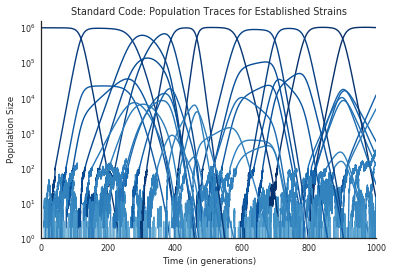

In [142]:
# plot results
strainlist = []
for bact in tqdm(sim.allStrains, desc='Looping through all strains'):
    try:
        strainlist.append((max(bact.poptrace), bact))
    except:
        strainlist.append((0, bact))
sortedlist = sorted(strainlist, key=lambda x: x[0])
endlist = [(i, bact) for i, (__, bact) in enumerate(reversed(sortedlist))]
shuffle(endlist)

n_big = 30
n_smol = len(sortedlist) - n_big
bigcolors = pl.cm.Blues(np.linspace(1,0.7, n_big))
smallcolors = pl.cm.Blues(np.linspace(0.7, 0, n_smol))
with sns.axes_style("white"):
    ind = 0
    for i, bact in tqdm((endlist), desc='Plotting Lineages'):
        if (i < 30) :
            t = bact.timepoints
            pop = bact.poptrace
            plt.semilogy(t, pop, color=bigcolors[i])
        elif (i % 20 == 0):
            t = bact.timepoints
            pop = bact.poptrace
            plt.semilogy(t, pop, color=smallcolors[i-n_big])
            
plt.xlabel('Time (in generations)')
plt.ylabel('Population Size')
plt.title('Standard Code: Population Traces for Established Strains')
plt.xlim([T_curr, T_sim])
plt.ylim([1e0, 10**(6.2)])
sns.despine()
plt.savefig('/home/jonathan/Lab/Fast Fail/Figures/Figure 3/3a_strain_traces_2.pdf')
plt.show()

Iteration Number: : 100%|██████████| 1000/1000 [00:19<00:00, 51.30it/s]
/usr/local/lib/python3.5/dist-packages/matplotlib/ticker.py:2206: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


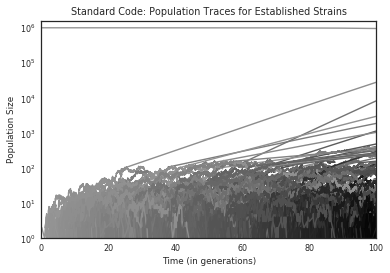

In [36]:
#############
# Figure 3a #
#############

# populate sim
LUCA = strain(N_pop=1e6, fitness=0, mu=2e-5)
sim = thunderflask(LUCA)
# initialize some variables
T_curr = 0
mut_param = [1, 2]
dt = 0.1
T_sim = 100

# run simulation
sim.simulate(T_sim, dt, T_curr, mut_param, save_all=True, prune_strains=True,
             show_progress=True)

n = len(sim.allStrains)
colors = pl.cm.Greys(np.linspace(1,0.5,n))
strainlist = [(i, bact) for i, bact in enumerate(reversed(sim.allStrains))]
shuffle(strainlist)
with sns.axes_style("white"):
    for i, bact in strainlist:
        t = bact.timepoints
        pop = bact.poptrace
        plt.semilogy(t, pop, color=colors[i])
# for i, (key, (times, pops)) in enumerate(sim.poptrace.items()):
#     if i % 10  == 0:
#         plt.semilogy(times, pops, color=colors[i])
plt.xlabel('Time (in generations)')
plt.ylabel('Population Size')
plt.title('Standard Code: Population Traces for Established Strains')
plt.xlim([T_curr, T_sim])
plt.ylim([1e0, 10**(6.2)])
#plt.savefig('/home/jonathan/Lab/Fast Fail/Figures/Figure 3/3a_strain_traces_2.svg')
plt.show()

In [65]:
#############
# Figure 3b #
#############
DF = pd.DataFrame()
filenames = [
#     '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/Standard_Code_1/output/2018-03-23_Standard_Code_1_concatenated.pickle', # standard code
#     '/home/jonathan/Dropbox/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/Colorado_0/output/2018-03-23_Colorado_0_concatenated.pickle', # colorado
#     '/home/jonathan/Dropbox/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/FF20_0/output/2018-03-23_FF20_0_concatenated.pickle', # FF20
#     '/home/jonathan/Dropbox/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/FF16_0/output/2018-03-23_FF16_0_concatenated.pickle', # FF16
    '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/RED20_0/output/2018-04-10_RED20_0_concatenated.pickle', # RED20
    '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/RED14_0/output/2018-04-10_RED14_0_concatenated.pickle', # RED14
    '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/PROMISC20_0/output/2018-04-12_PROMISC20_0_concatenated.pickle' # PROMISC20
]
# get dataframes
for file in filenames:
    with open(file, 'rb') as handle:
        df = pickle.load(handle)
#         df = df.loc[(df['time'] < 10)]
        DF = pd.concat([DF, df])
        del df
# with open(filenames[0], 'rb') as handle:
#     df = pickle.load(handle)

In [8]:
# extract dataframe for figure 3
codes_3b = ['Colorado', 'Standard Code']
codes_3c = list(set(DF['code']) - set(codes_3b))
f = lambda code: code in codes_3b
g = lambda code: not f(code)
DF_3b = DF.loc[DF['code'].map(f)]
DF_3c = DF.loc[DF['code'].map(g)]


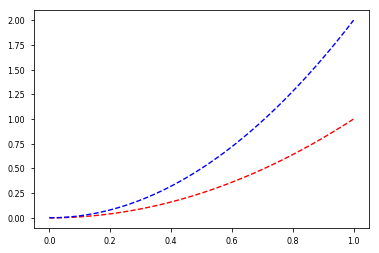

In [10]:
x = np.linspace(0,1)
y = x **2 
plt.plot(x, y, '--r')
plt.savefig('test.png')
plt.plot(x, y*2, '--b')
plt.savefig('test2.png')

In [68]:
# wanted_codes = ['Standard Code', 'Colorado', 'FF20']
wanted_codes= ['Reductionist20', 'PROMISC20']
f = lambda code: code in wanted_codes 
DF_3b = DF.loc[DF['code'].map(f)]

In [24]:
# optional individual dataframe loading
with open('/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/Standard_Code_1/output/2018-03-23_Standard_Code_1_concatenated.pickle', 'rb') as handle:
    df = pickle.load(handle)
    df_sc = df[(df['time'] > 100) & (df['time']) < 300]
    # df_sc.set_index(['code', 'sim'], inplace=True)
    del df
    
with open('/home/jonathan/Dropbox/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/Colorado_0/output/2018-03-23_Colorado_0_concatenated.pickle', 'rb') as handle:
    df = pickle.load(handle)
    df_col = df[(df['time'] > 100) & (df['time']) < 300]
    # df_col.set_index(['code', 'sim'], inplace=True)
    del df
    
# with open('/home/jonathan/Dropbox/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/FF20_0/output/2018-03-23_FF20_0_concatenated.pickle', 'rb') as handle:
#     df_ff20_3b = pickle.load(handle)   


/usr/local/lib/python3.5/dist-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


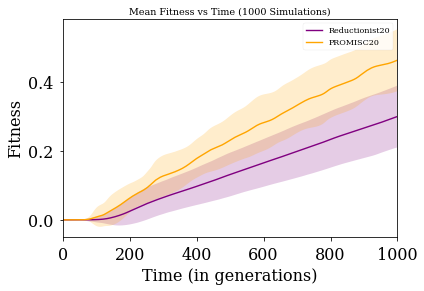

In [69]:
colordict = {
    'Colorado' : 'red',
    'Standard Code' : 'blue',
    'FF20': 'green',
    'Reductionist20' : 'purple',
    'PROMISC20' : 'orange'
}

ax1 = sns.tsplot(
    data=DF_3b, 
    time='time', 
    value='fitness', 
    unit='sim', 
    condition='code', 
    color=colordict, 
    ci='sd'
)
#ax2 = sns.tsplot(data=df_col_3b, time='time', value='fitness', unit='sim', condition='code', color='red')
#ax3 = sns.tsplot(data=df_ff20_3b, time='time', value='fitness', unit='sim', condition='code', color='green')

plt.legend()
plt.title('Mean Fitness vs Time (1000 Simulations)')
plt.xlabel('Time (in generations)')
plt.ylabel('Fitness')
#plt.savefig('/home/jonathan/Lab/Fast Fail/Figures/Figure 3/3b_fit_traces.pdf')
plt.show()

In [32]:
code = 'FF20'
DF_3b.loc[DF_3b['code'] == code].loc[7]['time'].iloc[0]
# fitnesses[code] = [df.loc[i, 'fitness'].iloc[nFrame-bumper] for i in sims]

0.7000700070007

In [52]:
################
# Figures 3c-d #
################
sims = set(DF_3b['sim'])
codes = set(DF_3b['code'])
lags = []
rates = []
# loop over codes
for code in tqdm(codes, desc='Looping over Codes'):
    # declare storage variables
    t_lag = np.zeros(len(sims))
    rate = np.zeros(len(sims))
    DF = DF_3b.loc[DF_3b['code'] == code]
    for i, sim in enumerate(tqdm(sims, desc='Looping over Sims')):
        # extract data for this sim
        data = DF.loc[DF['sim'] == sim]
        t = data['time'].values
        f = data['fitness'].values
        # smooth with gaussian filter
        gaussian_filter = gaussian(30, 10)
        filtered_signal = convolve1d(f, gaussian_filter/gaussian_filter.sum())
        # calculate first derivative  
        delt = np.diff(t)
        t_avg = (t[1:]+t[:-1])/2
        filt_grad = np.diff(filtered_signal)/delt
        # find peaks
        peak_ind = peakutils.indexes(filt_grad, thres=0.05, min_dist=int(30/delt.mean()))
        # get timestamp for this point
        t_lag[i] = t_avg[peak_ind[0]]
        t_ind = int(peak_ind[0])
        # get estimate for evolutionary rate
        dt = t[-1]  - t[t_ind]
        dx = f[-1] - f[t_ind]
        rate[i] = dx/dt
    # store arrays in list
    lags.append(t_lag)
    rates.append(rate)
           
# collate data into a dataframe
dfs = []
for (lag, rate, code) in zip(lags, rates, codes):
    d = pd.DataFrame({
        'lag' : lag,
        'rate' : rate,
        'code' : [code for i in range(len(lag))]
    })
    dfs.append(d)
DF_3cd = pd.concat(dfs)

HBox(children=(IntProgress(value=0, description='Looping over Codes: ', max=3), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Looping over Sims: ', max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Looping over Sims: ', max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Looping over Sims: ', max=1000), HTML(value='')))

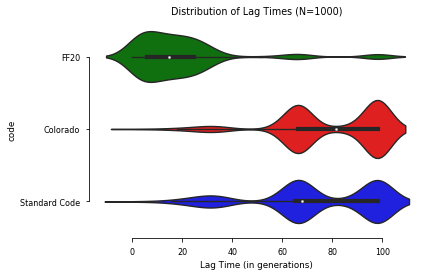

In [70]:
# plot violin plots for lag times
ax = sns.violinplot(
    x='lag', 
    y='code', 
    data=DF_3cd, 
    palette=colordict, 
    inner='box',
)
plt.title('Distribution of Lag Times (N=1000)')
plt.xlabel('Lag Time (in generations)')
sns.despine(trim=True)

#plt.savefig('bonkers.pdf')

Text(0.5,0,'Evolutionary Rates (in 1/generations)')

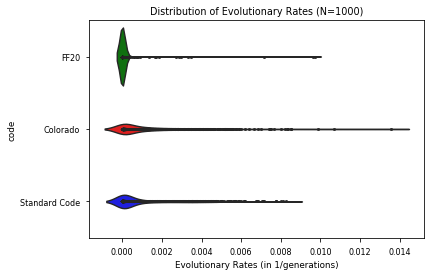

In [41]:
# plot violin plots for lag times
ax = sns.violinplot(x='rate', y='code', data=DF_3cd, palette=colordict, inner='point')
plt.title('Distribution of Evolutionary Rates (N=1000)')
plt.xlabel('Evolutionary Rates (in 1/generations)')
#plt.savefig('bonkers.pdf')

HBox(children=(IntProgress(value=0, description='Looping through codes: ', max=3), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Looping through sims: ', max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Looping through sims: ', max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Looping through sims: ', max=1000), HTML(value='')))

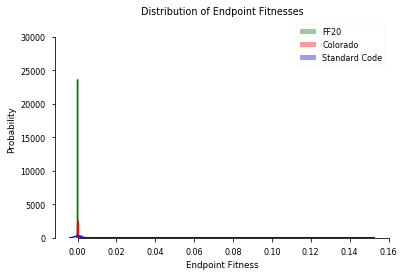

In [9]:
#############
# Figure 3e #
#############
# get endpoint fitness from simulations
sims = set(DF_3b['sim'])
codes = set(DF_3b['code'])
colordict = {
    'Colorado' : 'red',
    'Standard Code' : 'blue',
    'FF20': 'green'
}
endpoints = {}
for code in tqdm(codes, desc='Looping through codes'):
    endpoints[code] = []
    df = DF_3b.loc[DF_3b['code'] == code]
    for sim in tqdm(sims, desc='Looping through sims'):
        endpoints[code].append(df.loc[df['sim'] == sim,'fitness'].iloc[-1])
        sns.despine(trim=True)
DF_endtimes = pd.DataFrame.from_dict(endpoints)

# plot distribution
for code in codes:
    sns.distplot(DF_endtimes[code], kde=True, hist=True, rug=False, norm_hist=True, color=colordict[code], label=code, rug_kws={"alpha" : 0.03})
# plt.xlim([0,0.6])
sns.despine(trim=True)
plt.xlabel('Endpoint Fitness')
plt.ylabel('Probability')
plt.legend()
plt.title('Distribution of Endpoint Fitnesses')
ax = plt.gca()
imgs = [obj for obj in ax.get_children() if isinstance(obj, mpl.image.AxesImage)]

#plt.savefig('Endtime Dist (Hist and KDE).svg')

NameError: name 'DF_3b' is not defined

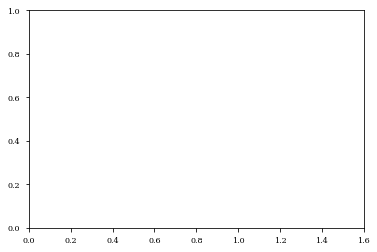

In [32]:
##############################################
# Sup Video: Distribution Evolving Over Time #
##############################################

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 1.6))

# define general parameters
sims = set(DF_3b['sim'])
codes = set(DF_3b['code'])
colordict = {
    'Colorado' : 'red',
    'Standard Code' : 'blue',
    'FF20': 'green'
}

# define video parameters
fps = 3
bumper = 0#30
skip = 10
frames = int( (len(DF_3b.loc[(DF_3b['code'] == 'FF20') & (DF_3b['sim'] == 1)]['time']) - bumper) / skip -1 )
dpi = 100
# frames = 100
# # define frame generating function
# def framer(nFrame):
#     plt.cla()
#     # get current fitness from simulations
#     fitnesses = {}
#     for code in codes:
#         df = DF_3b.loc[DF_3b['code'] == code].set_index('sim')
#         fitnesses[code] = [df.loc[i, 'fitness'].iloc[(nFrame-bumper)] for i in sims]
#         t = df.loc[0, 'time'].iloc[nFrame-bumper]
#     DF_times = pd.DataFrame.from_dict(fitnesses)

#     # plot distribution
#     for code in codes:
#         ax = sns.distplot(DF_times[code], kde=False, hist=True, rug=False, norm_hist=True, color=colordict[code], label=code)
#     plt.xlim([0,1.6])
# #     plt.yticks(visible=False)
# #     ax.yaxis.grid(False)
#     sns.despine(trim=True)
#     plt.xlabel('Fitness')
#     plt.ylabel('Probability')
#     t_before_decimal = int(t)
#     t_after_decimal = t - t_before_decimal
#     t_string = str(t_before_decimal) + str(t_after_decimal)[1:3]
#     plt.title('Distribution of Fitnesses (t={0})'.format(t_string))
#     plt.legend()
    
def framer(nFrame):
    plt.cla()
    # adjust frame with offset
    framenum = int((nFrame + bumper)*skip)
    # get current fitness from simulations
    data = DF_3b.loc[framenum]

    # plot distribution
    for code in codes:
        ax = sns.distplot(data.loc[data['code'] == code]['fitness'], kde=True, hist=True, rug=False, norm_hist=True, color=colordict[code], label=code)
    plt.xlim([0,1.6])
#     ax.yaxis.grid(False)
    sns.despine(left=True)
    ax.axes.get_yaxis().set_visible(False)
    plt.xlabel('Fitness')
    plt.ylabel('Probability')
    t = data['time'].iloc[0]
    t_before_decimal = int(t)
    t_after_decimal = t - t_before_decimal
    t_string = str(t_before_decimal) + str(t_after_decimal)[1:3]
    plt.title('Distribution of Fitnesses (t={0})'.format(t_string))
    plt.legend()

# framer(5)
# anim = animation.FuncAnimation(fig, framer, frames=frames)
# anim.save('test.gif', writer='imagemagick', fps=fps, dpi=dpi);

## Figure 4: Fast fail codes can underpin intrinsic biocontainment

In [2]:
# get contour dataframes
DF = pd.DataFrame()
# # log filenames
# filenames = [
#     '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_SC_contour_0/output/2018-04-12_SC_vs_SC_contour_0_concatenated.pickle', # vs SC
#     '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_Colorado_contour_0/output/2018-04-11_SC_vs_Colorado_contour_0_concatenated.pickle', # vs colorado
#     '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_FF20_contour_0/output/2018-04-11_SC_vs_FF20_contour_0_concatenated.pickle', # vs ff20
#     '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_RED20_contour_0/output/2018-04-11_SC_vs_RED20_contour_0_concatenated.pickle', # vs red20
#     '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_FF16_contour_1/output/2018-04-11_SC_vs_FF16_contour_1_concatenated.pickle', # vs ff16
#     '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_RED14_contour_0/output/2018-04-11_SC_vs_RED14_contour_0_concatenated.pickle', # vs red14
# ]
# lin filenames
filenames = [
    '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_SC_lin_contour_0/output/2018-04-12_SC_vs_SC_lin_contour_0_concatenated.pickle', # vs SC lin
#     '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_Colorado_lin_contour_0/output/2018-04-12_SC_vs_Colorado_lin_contour_0_concatenated.pickle', # vs colorado lin
#     '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_FF20_lin_contour_0/output/2018-04-12_SC_vs_FF20_lin_contour_0_concatenated.pickle', # vs FF20 lin
#     '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_FF16_lin_contour_0/output/2018-04-12_SC_vs_FF16_lin_contour_0_concatenated.pickle', # vs FF16 lin
#     '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_RED20_lin_contour_0/output/2018-04-12_SC_vs_RED20_lin_contour_0_concatenated.pickle', # vs RED20 lin
#     '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_RED14_lin_contour_0/output/2018-04-12_SC_vs_RED14_lin_contour_0_concatenated.pickle', # vs RED14
#     '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_PROMISC20_lin_contour_0/output/2018-04-13_SC_vs_PROMISC20_lin_contour_0_concatenated.pickle', # vs PROMISC20
#     '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_PROMISC14_lin_contour_1/output/2018-04-13_SC_vs_PROMISC14_lin_contour_1_concatenated.pickle', # vs PROMISC14
]
# get dataframes
dfs = []
for file in filenames:
    with open(file, 'rb') as handle:
        dfs.append(pickle.load(handle))
DF = pd.concat(dfs, copy=False)

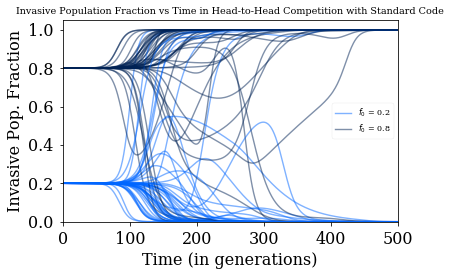

In [90]:
# 4a: show individual traces
def tracer(DF, code, linestyle='-', color=None, label=None):
    df = DF.loc[DF['code'] == code]
    sims = set(df['sim'])
    colordict = {
        'Standard Code' : 'blue',
        'Colorado' : 'red',
        'FF20' : 'green',
        'FF16' : 'orange',
        'RED20' : 'purple',
        'RED14' : 'brown'
    }
    if color == None: color = colordict[code]
    for sim in sims:
        lildf = df.loc[df['sim'] == sim]
        t = lildf['time']
        x = lildf['popfrac'] / 1e6
        label = code if sim == 0 else ''
        plt.plot(t, x*1e6, linestyle, color=color, alpha=0.7, label=label)

# set figure options
labelsize=16
width = 6
height = width / 1.618
alpha = 0.5

# define blue shades
dark_blue = '#002255'
light_blue = '#0066ff'

# define low and high popfrac
lowfrac = 0.2
highfrac = 0.8

# define linestyles and colorshades
linestyle = {
    str(lowfrac): ('-', light_blue),
    str(highfrac): ('-', dark_blue)
}

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=labelsize)
plt.rc('ytick', labelsize=labelsize)
plt.rc('axes', labelsize=labelsize)

# plot traces
# 4a: show individual traces
df = DF.loc[DF['N_0'].map(lambda n_0: n_0/1e6 in [lowfrac, highfrac])]
sims = list(set(df['sim']))
shuffle(sims)
label_small = True
label_large = True
for sim in sims:
    if (sim % 2) == 0:
        lildf = df.loc[df['sim'] == sim]
        n_0 = lildf['N_0'][0]/1e6
        line, color = linestyle[str(n_0)]
        if n_0 == lowfrac:
            if label_small:
                label = r'$f_0$ = {0}'.format(lowfrac)
                label_small = False
            else:
                label = ''
        else:
            if label_large:
                label = r'$f_0$ = {0}'.format(highfrac)
                label_large = False
            else:
                label = ''
        plt.plot(lildf['time'], lildf['popfrac'], line, label=label, color=color, alpha=alpha)

plt.ylim([0,1.05])
plt.xlim([0,500])
# plt.yticks([0, 0.25, 0.5, 0.75, 1])
plt.title('Invasive Population Fraction vs Time in Head-to-Head Competition with Standard Code')
plt.xlabel('Time (in generations)')
plt.ylabel('Invasive Pop. Fraction')
plt.legend()
fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(width, height)
# ax.set_xscale("log")
plt.savefig('/home/jonathan/Lab/Fast Fail/Figures/Figure 4/4a_individual_traces.svg')
plt.show()

In [3]:
# generate probabilities
def contain_probability(DF, code):
    df = DF.loc[DF['code'] == code]
    N_0 = list(set(df['N_0']))
    N_0.sort()
    num_sims = len(df.loc[df['N_0'] == N_0[0]].loc[0])
    t = df.loc[df['sim'] == 0]['time']
    contain_probability = np.zeros((len(N_0), len(t)))
    for i, n_0 in enumerate(tqdm(N_0, desc='Processing Initial Conditions: ', leave=False)):
        lildf = df.loc[df['N_0'] == n_0]
        for j in tqdm(range(len(t)), desc='Processing sims: '):
            weedf = lildf.loc[j]
            contain_probability[i, j] = sum(weedf['popfrac'] == 0) / num_sims
            
    return contain_probability, t, N_0

In [17]:
# get traces for endpoint containment probabilities
def endpoint_contain(DF, code):
    df = DF.loc[DF['code'] == code]
    N_0 = list(set(df['N_0']))
    N_0.sort()
    num_sims = len(df.loc[df['N_0'] == N_0[0]].loc[0])
    timedf = df.loc[df['sim'] == 0]['time']
    endt = df.iloc[-1]
    endind = df.index[-1]
    df = df.loc[endind]
    contain = np.zeros(len(N_0))
    for i, n_0 in enumerate(N_0):
        lildf = df.loc[df['N_0'] == n_0]
        contain[i] = sum(lildf['popfrac'] == 0) / num_sims
    return contain, N_0

In [19]:
code = 'Standard'
df = DF.loc[DF['code'] == code]
N_0 = list(set(df['N_0']))
N_0.sort()
N_0[-1]

1000000.0

In [2]:
Standard_contour, t, N_0 = contain_probability(DF, 'Standard')
Colorado_contour, t, N_0 = contain_probability(DF, 'Colorado')
FF20_contour, t, N_0 = contain_probability(DF, 'FF20')
FF16_contour, t, N_0 = contain_probability(DF, 'FF16')
RED20_contour, t, N_0 = contain_probability(DF, 'RED20')
RED14_contour, t, N_0 = contain_probability(DF, 'RED14')
PROMISC20_contour, t, N_0 = contain_probability(DF, 'PROMISC20')
PROMISC14_contour, t, N_0 = contain_probability(DF, 'PROMISC14')

In [ ]:
# pickle results for faster access
with open('/home/jonathan/Lab/ATD/codon-tables/data/manuscript/fig4/contour_caching_lin.pickle', 'wb') as handle:
    data = [FF20_contour, FF16_contour, RED20_contour, RED14_contour, Colorado_contour, Standard_contour, PROMISC20_contour, PROMISC14_contour, t, N_0]
    pickle.dump(data, handle)

In [2]:
# unpickle for faster access
with open('/home/jonathan/Lab/ATD/codon-tables/data/manuscript/fig4/contour_caching_lin.pickle', 'rb') as handle:
    FF20_contour, FF16_contour, RED20_contour, RED14_contour, Colorado_contour, Standard_contour, PROMISC20_contour, PROMISC14_contour, t, N_0 = pickle.load(handle)

In [40]:
colordict = {
    'Standard' : 'blue',
    'Colorado' : 'red',
    'FF20' : 'green',
    'FF16' : 'orange',
    'RED20' : 'purple',
    'RED14' : 'brown'
}

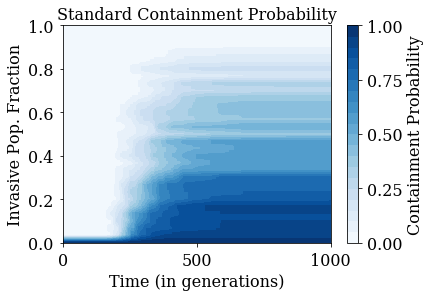

In [18]:
# generate log contour plot
contours = {
    'Standard':Standard_contour,
    'Colorado':Colorado_contour,
    'FF20':FF20_contour,
    'FF16':FF16_contour,
    'RED20':RED20_contour,
    'RED14':RED14_contour
}
cmaps = {
    'Standard':plt.cm.Blues,
    'Colorado':plt.cm.Reds,
    'FF20':plt.cm.Greens,
    'FF16':plt.cm.Oranges,
    'RED20':plt.cm.Purples,
    'RED14':plt.cm.copper_r
}

code = 'Standard'
contour = contours[code]
cmap = cmaps[code]

# set figure options
labelsize=16
width = 4
height = width / 1.618

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=labelsize)
plt.rc('ytick', labelsize=labelsize)
plt.rc('axes', labelsize=labelsize)

X, Y = np.meshgrid(t, np.array(N_0)/1e6)
CS = plt.contourf(X, Y, contour, 20, cmap=cmap, vmin=0, vmax=1)
#plt.clabel(CS, inline=1, fontsize=10)
ax = plt.gca()
# ax.set_yscale("log")
# plt.xlim([0, 500])
# plt.ylim([3e3, 1e6])
# plt.yticks([1e0, 1e2, 1e4, 1e6])
plt.xticks([0, 500, 1000])
# ax.set_xscale("log")

cbar = plt.colorbar(CS, ticks=[0, 0.25, 0.5, 0.75, 1])
cbar.ax.set_ylabel('Containment Probability')
plt.clim(0,1)

path = '/home/jonathan/Lab/Fast Fail/Figures/Figure 4/'
# Add the contour line levels to the colorbar
plt.title('{0} Containment Probability'.format(code), fontsize=labelsize)
plt.xlabel('Time (in generations)')
plt.ylabel('Invasive Pop. Fraction')
# plt.savefig(path+'{0}_contour_log.svg'.format(code))
plt.show()

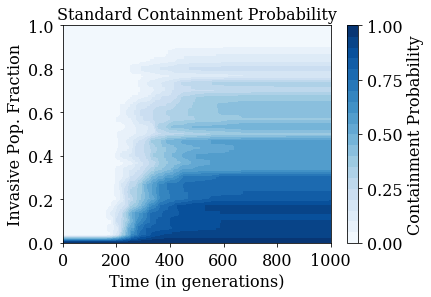

In [19]:
# 4b: generate linear contour plot
contours = {
    'Standard':Standard_contour,
    'Colorado':Colorado_contour,
    'FF20':FF20_contour,
    'FF16':FF16_contour,
    'RED20':RED20_contour,
    'RED14':RED14_contour,
    'PROMISC20':PROMISC20_contour,
    'PROMISC14':PROMISC14_contour
}
cmaps = {
    'Standard':plt.cm.Blues,
    'Colorado':plt.cm.Reds,
    'FF20':plt.cm.Greens,
    'FF16':plt.cm.Oranges,
    'RED20':plt.cm.Purples,
    'RED14':plt.cm.copper_r,
    'PROMISC20':plt.cm.Purples,
    'PROMISC14':plt.cm.copper_r
}

code = 'Standard'
contour = contours[code]
cmap = cmaps[code]

X, Y = np.meshgrid(t, np.array(N_0)/1e6)
CS = plt.contourf(X, Y, contour, 20, cmap=cmap, vmin=0, vmax=1)
#plt.clabel(CS, inline=1, fontsize=10)
ax = plt.gca()
# plt.ticklabel_format(style='sci', axis='y')
# plt.xlim([0, 500])
# plt.yticks([])
# plt.xticks([])
# ax.set_xscale("log")


cbar = plt.colorbar(CS, ticks=[0, 0.25, 0.5, 0.75, 1])
cbar.ax.set_ylabel('Containment Probability')
plt.clim(0,1)

path = '/home/jonathan/Lab/Fast Fail/Figures/Figure 4/'
# Add the contour line levels to the colorbar
plt.title('{0} Containment Probability'.format(code), fontsize=labelsize)
plt.xlabel('Time (in generations)')
plt.ylabel('Invasive Pop. Fraction')
plt.savefig(path+'{0}_contour_lin.svg'.format(code))
plt.show()

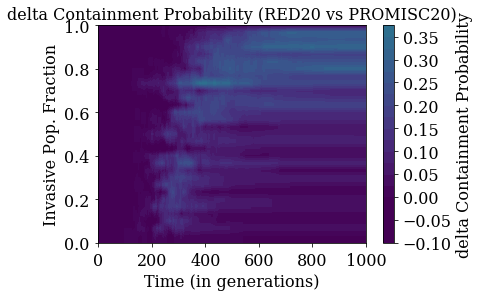

In [16]:
X, Y = np.meshgrid(t, np.array(N_0)/1e6)
CS = plt.contourf(X, Y, (RED20_contour - PROMISC20_contour), 20, cmap=plt.cm.viridis)
#plt.clabel(CS, inline=1, fontsize=10)
ax = plt.gca()
# plt.xlim([0, 500])
# plt.ylim([3e3, 1e6])
# ax.set_xscale("log")
# ax.set_yscale("log")

# set figure options
labelsize=16
width = 4
height = width / 1.618

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=labelsize)
plt.rc('ytick', labelsize=labelsize)
plt.rc('axes', labelsize=labelsize)

cbar = plt.colorbar(CS)#, ticks=[0, 0.25, 0.5, 0.75, 1])
cbar.ax.set_ylabel('delta Containment Probability')
plt.clim(0,1)

path = '/home/jonathan/Lab/Fast Fail/Figures/Figure 4/'
# Add the contour line levels to the colorbar
plt.title('delta Containment Probability (RED20 vs PROMISC20)', fontsize=labelsize)
plt.xlabel('Time (in generations)')
plt.ylabel('Invasive Pop. Fraction')
plt.savefig(path+'delta_RED20.svg')
plt.show()

In [21]:
colordict = {
    'Standard' : 'blue',
    'Colorado' : 'red',
    'FF20' : 'green',
    'FF16' : 'orange',
    'RED20' : 'purple',
    'RED14' : 'brown',
    'PROMISC20': 'purple',
    'PROMISC14': 'brown'
}

# massage data for endpoint analysis

# lin filenames
filenames = [
    '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_SC_lin_contour_0/output/2018-04-12_SC_vs_SC_lin_contour_0_concatenated.pickle', # vs SC lin
    '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_Colorado_lin_contour_0/output/2018-04-12_SC_vs_Colorado_lin_contour_0_concatenated.pickle', # vs colorado lin
    '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_FF20_lin_contour_0/output/2018-04-12_SC_vs_FF20_lin_contour_0_concatenated.pickle', # vs FF20 lin
    '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_FF16_lin_contour_0/output/2018-04-12_SC_vs_FF16_lin_contour_0_concatenated.pickle', # vs FF16 lin
    '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_RED20_lin_contour_0/output/2018-04-12_SC_vs_RED20_lin_contour_0_concatenated.pickle', # vs RED20 lin
    '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_RED14_lin_contour_0/output/2018-04-12_SC_vs_RED14_lin_contour_0_concatenated.pickle', # vs RED14
    '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_PROMISC20_lin_contour_0/output/2018-04-13_SC_vs_PROMISC20_lin_contour_0_concatenated.pickle', # vs PROMISC20
    '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_PROMISC14_lin_contour_1/output/2018-04-13_SC_vs_PROMISC14_lin_contour_1_concatenated.pickle', # vs PROMISC14
]
# get dataframes
dfs = []
for file in tqdm(filenames, desc = 'grabbing dataframes'):
    with open(file, 'rb') as handle:
        dfs.append(pickle.load(handle).loc[1000])
DF = pd.concat(dfs, copy=False)
N_0 = list(set(DF.loc[DF['code'] == 'Standard']['N_0']))
N_0.sort()
num_reps = len(DF.loc[(DF['N_0']==N_0[0]) & (DF['code'] == 'Standard')])

for code in tqdm(colordict.keys(), desc='colors'):
#     lilDF = DF.loc[DF['code'] == code]
    for n_0 in tqdm(N_0, desc='initial conditions'):
        DF.loc[(DF['code'] == code)&(DF['N_0'] == n_0), 'sim'] = np.arange(num_reps)
#         weeDF = lilDF.loc[lilDF['N_0'] == n_0]
#         weeDF['sim'] = np.arange(num_reps)

# convert to containment and popfrac
DF.loc[:,'popfrac'] = (DF.loc[:,'popfrac'] == 0)
DF.loc[:,'N_0'] /= 1e6

HBox(children=(IntProgress(value=0, description='grabbing dataframes: ', max=8), HTML(value='')))

HBox(children=(IntProgress(value=0, description='colors: ', max=8), HTML(value='')))

HBox(children=(IntProgress(value=0, description='initial conditions: ', max=31), HTML(value='')))

HBox(children=(IntProgress(value=0, description='initial conditions: ', max=31), HTML(value='')))

HBox(children=(IntProgress(value=0, description='initial conditions: ', max=31), HTML(value='')))

HBox(children=(IntProgress(value=0, description='initial conditions: ', max=31), HTML(value='')))

HBox(children=(IntProgress(value=0, description='initial conditions: ', max=31), HTML(value='')))

HBox(children=(IntProgress(value=0, description='initial conditions: ', max=31), HTML(value='')))

HBox(children=(IntProgress(value=0, description='initial conditions: ', max=31), HTML(value='')))

HBox(children=(IntProgress(value=0, description='initial conditions: ', max=31), HTML(value='')))

In [135]:
# 4c: generate endpoint probabilities for nonpromiscuous codes
df = DF.loc[DF['code'].map(lambda code: code not in ['PROMISC20', 'PROMISC14'])]
# adjust independent variable to be pop fraction
N_0.sort()
x = np.array(N_0)/1e6
for code, color in colordict.items():
    # get array at last timepoint
    y = contours[code][:,-1]
    # plot
    plt.plot(np.array(x), y, color, label=code)
plt.legend()
plt.xlabel('Initial Population Fraction')
plt.ylabel('Endpoint Containment Probability')
ax = plt.gca()
# ax.set_xscale("log")
plt.savefig('test.svg')
plt.show()

NameError: name 'contours' is not defined

/usr/local/lib/python3.5/dist-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


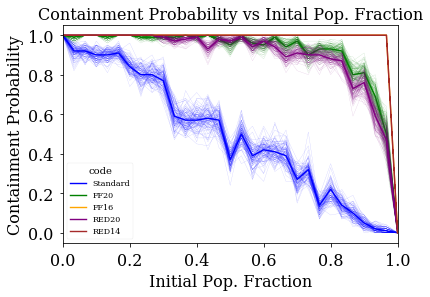

In [22]:
# 4c: generate endpoint probabilities for nonpromiscuous codes
# set figure options
labelsize=16
width = 4
height = width / 1.618

df = DF.loc[DF['code'].map(lambda code: code not in ['Colorado', 'PROMISC20', 'PROMISC14'])]
sns.tsplot(data=df, time='N_0', value='popfrac', unit='sim', condition='code', err_style='boot_traces', n_boot=100, color=colordict)


plt.rc('font', family='serif')
plt.rc('xtick', labelsize=labelsize)
plt.rc('ytick', labelsize=labelsize)
plt.rc('axes', labelsize=labelsize)

ax = plt.gca()
# plt.xlim([0, 1])
# plt.ylim([])
# plt.yticks([])
# plt.xticks([])

path = '/home/jonathan/Lab/Fast Fail/Figures/Figure 4/'
plt.title('Containment Probability vs Inital Pop. Fraction'.format(code), fontsize=labelsize)
plt.ylabel('Containment Probability')
plt.xlabel('Initial Pop. Fraction')
plt.savefig(path+'4c_contain_prob_vs_init_cond.svg')
plt.show()

## Figure 5: tRNA Promiscuity Does Not Impair Biocontainment

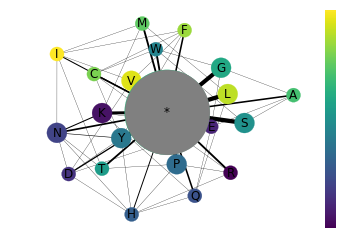

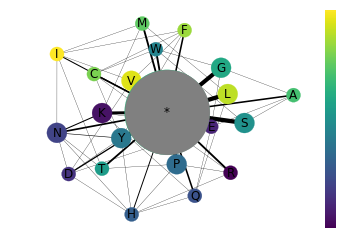

In [31]:
##############
# Figures 5a #
##############

# plot and save some shiznit
path = '/home/jonathan/Lab/Fast Fail/Figures/Figure 5/'
#fftable.plotGraph()#filename=path+'ff_graph.svg')
#ff16_table.codonTable.to_csv(path+'ff16.csv')
#f16_table.plotGraph(filename=path+'ff16_graph.svg')
# red20.plotGraph(filename=path+'reductionist_graph.svg')
# red20.codonTable.to_csv(path+'red20.csv')
# red14.plotGraph(filename=path+'reduct14_graph.svg')
# red14.codonTable.to_csv(path+'red14.csv')
# promisc20.plotGraph(filename=path+'promisc20_graph.svg')
# promisc14.plotGraph(filename=path+'promisc14_graph.svg')

In [4]:
##############
# Figures 5b #
##############

filenames = [
#     '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/Standard_Code_1/output/2018-03-23_Standard_Code_1_concatenated.pickle', # standard code
#     '/home/jonathan/Dropbox/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/Colorado_0/output/2018-03-23_Colorado_0_concatenated.pickle', # colorado
#     '/home/jonathan/Dropbox/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/FF20_0/output/2018-03-23_FF20_0_concatenated.pickle', # FF20
#     '/home/jonathan/Dropbox/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/FF16_0/output/2018-03-23_FF16_0_concatenated.pickle', # FF16
#     '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/RED20_0/output/2018-04-10_RED20_0_concatenated.pickle', # RED20
#     '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/RED14_0/output/2018-04-10_RED14_0_concatenated.pickle', # RED14
    '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/PROMISC20_0/output/2018-04-12_PROMISC20_0_concatenated.pickle', # PROMISC20
#     '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/PROMISC14_0/output/2018-04-13_PROMISC14_0_concatenated.pickle' # PROMISC14
]
# get dataframes
dfs = []
for file in filenames:
    with open(file, 'rb') as handle:
        dfs.append(pickle.load(handle))
DF = pd.concat(dfs, copy=False)

In [5]:
DF

,code,fitness,sim,time
0,PROMISC20,0.000000e+00,0,0.00000
1,PROMISC20,0.000000e+00,0,0.10001
2,PROMISC20,0.000000e+00,0,0.20002
3,PROMISC20,3.362948e-11,0,0.30003
4,PROMISC20,1.599398e-08,0,0.40004
5,PROMISC20,1.119130e-08,0,0.50005
6,PROMISC20,2.491139e-08,0,0.60006
7,PROMISC20,3.274679e-08,0,0.70007
8,PROMISC20,2.733776e-08,0,0.80008
9,PROMISC20,2.192872e-08,0,0.90009


/usr/local/lib/python3.5/dist-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


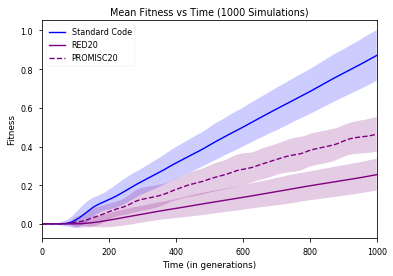

In [13]:
colordict = {
    'Standard Code' : 'blue',
    'Colorado' : 'red',
    'FF20' : 'green',
    'FF16' : 'orange',
    'RED20' : 'purple',
    'RED14' : 'brown',
    'PROMISC20': 'purple',
    'PROMISC14': 'brown'
}


f = lambda code: code not in ['PROMISC20', 'PROMISC14']
ax1 = sns.tsplot(
    data=DF.loc[DF['code'].map(f)], 
    time='time', 
    value='fitness', 
    unit='sim', 
    condition='code', 
    color=colordict, 
    ci='sd',
    linestyle='-'
)
ax2 = sns.tsplot(
    data=DF.loc[(DF['code'].map(lambda code: not f(code)))], 
    time='time', 
    value='fitness', 
    unit='sim', 
    condition='code', 
    color=colordict, 
    ci='sd',
    linestyle='--'
)
# ax2 = sns.tsplot(data=df_col_3b, time='time', value='fitness', unit='sim', condition='code', color='red')
#ax3 = sns.tsplot(data=df_ff20_3b, time='time', value='fitness', unit='sim', condition='code', color='green')

plt.legend()
plt.title('Mean Fitness vs Time (1000 Simulations)')
plt.xlabel('Time (in generations)')
plt.ylabel('Fitness')
#plt.savefig('/home/jonathan/Lab/Fast Fail/Figures/Figure 3/3b_fit_traces.pdf')
plt.show()